# Importing dependencies and all required functions

In the previous notebook (ModelTraining_Notebook.ipynb) the optimal models were developed by considering different spectral preprocessing techniques and spectral wavelength ranges. This notebook will exploit the developed models on different samples to understand their performance further

The cell below imports dependencies from the script files in the folder Import_Scripts

In [1]:
import sys
import os
# Get the path of the directory where the script is located
script_path = os.getcwd()

os.chdir(script_path+'/Import_Scripts')
# The five scripts below contain all the functions used in this and other notebooks
from NIR_ImportExport import *
from NIR_Metrics import *
from NIR_Plots import *
from NIR_Preprocessing import *
from NIR_Training import *
from NIR_Uncertainty import *

os.chdir(script_path)

# Data import from excel file

The cell below imports the required spectral data from an Excel spreadsheet in the main folder. The entire excel file is imported and then segmented into training and testing datasets based on the user defined categorisation in the excel file (example is given in this repository)

In [2]:
file_name="Training_Testing_Data_ModelDevelopment.xlsx" # Imports the training and testing data from the excel file
_, wavelength, spectra_raw=file_import(file_name,'Reflectance') # Extracts the spectral data and the wavelength

training_set = pd.read_excel(file_name, sheet_name="Names",header=0).loc[:,'Training?'].values=="Y" # Gets the indices of the training set
testing_set = pd.read_excel(file_name, sheet_name="Names",header=0).loc[:,'Testing?'].values=="Y" # Gets the indices of the testing set
comp_dataset = pd.read_excel(file_name, sheet_name="Compositions",header=0) ; comp_headers=['Glucan','Hemicellulose','Lignin'] # Gets the compositions
comp_vals=comp_dataset.loc[:,comp_headers].values ; comp_vals_train=comp_vals[training_set] ; comp_vals_test=comp_vals[testing_set] # Segments the compositions into training and testing datasets as defined in the excel file

spectra_raw_avg=spectra_avg(spectra_raw, num_repeats=4) # Averages the spectral data (Assumes 4 repeats)

preprocess_labels=['Raw','SNV','MSC','SNV(Detrend)','1st Derivative','2nd Derivative','Centered', \
    'SG1-SNV','SG1-MSC','SG2-SNV','SG2-MSC']

# Parity Plots

The following cell performs preprocessing for the desired dataset and wavelength limit

In [3]:
dataset_needed = 'SNV' ; low_nm = 948 ; up_nm = 2500
ind = preprocess_labels.index(dataset_needed)

_, X_train_all, X_test_all = preprocessing_combined(low_nm, up_nm, spectra_raw_avg, wavelength, spectra_raw, training_set, testing_set)
X_train = X_train_all[:,:,ind] ; X_test = X_test_all[:,:,ind]

(389, 149)
(389, 49)


### Training of Uncertainty-based Models

#### Training Cells (can be skipped)

The following cell uses the uncertainty estimation framework outlined in Odgers et al. (https://github.com/jamesacodgers/bootstrapPLS). This saves a model using pickle which can be called later. \
*WARNING*: This cell takes about 10 minutes to run. The cell can be skipped and the saved model be loaded in the following cells

In [ ]:
### New Training - Char 25/12
n_l = 7
X=X_train ; y = comp_vals_train
pls = PLS(X,y,n_l)
n_s = pls.n_s
pls.gen_boot_params(n_b = 1000)

filename = 'Uncertainty_Models/CharModel.pkl'
pkl.dump(pls, open(filename,'wb'))

The trained uncertainty model can then be used to get the uncertainty estimates for the training and testing datasets. This will provide an idea of how the confident the model is in its predictions. \
*WARNING*: These cell takes about 2 hours to run. They cell can be skipped and the saved results be loaded in the following cells

The following cells run the uncertainty estimation for the training and testing data points.

In [ ]:
filename = 'Uncertainty_Models/CharModel.pkl'
pls = pkl.load(open(filename, 'rb'))

In [ ]:
y_ovr_test = uncertainty_estimation(pls, X_test, n_points = 100)
filename_test = 'UncertaintyResults/pls_uncertainty_results_testing.pkl'
pkl.dump(y_ovr_test, open(filename_test,'wb'))

In [ ]:
y_ovr_train = uncertainty_estimation(pls, X_test, n_points = 100)
filename_train = 'UncertaintyResults/pls_uncertainty_results_training.pkl'
pkl.dump(y_ovr_train, open(filename_train,'wb'))

#### Plotting Cells

The saved data can then be imported and run to generate parity plots

In [4]:
filename_train = 'UncertaintyResults/pls_uncertainty_results_training.pkl'
filename_test = 'UncertaintyResults/pls_uncertainty_results_testing.pkl'
y_ovr_train = pkl.load(open(filename_train, 'rb'))
y_ovr_test = pkl.load(open(filename_test, 'rb'))

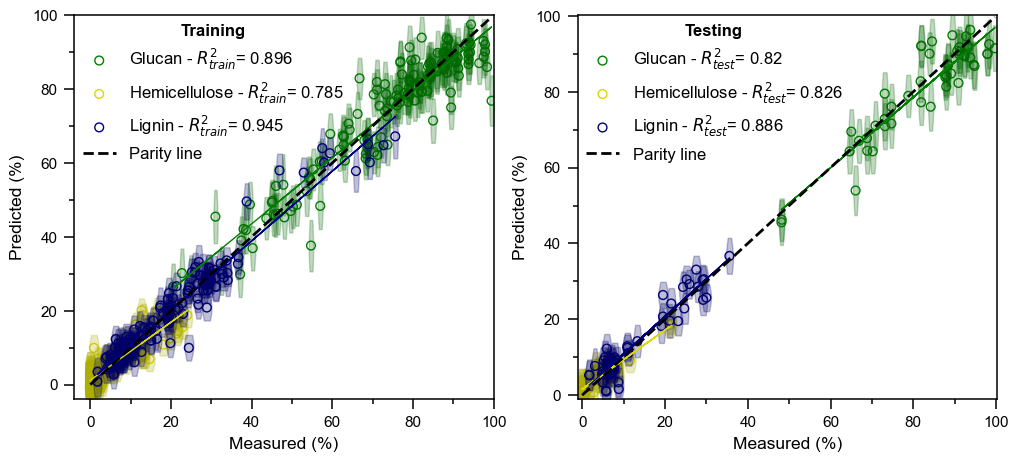

In [5]:
y_hat_train, y_pos_train, y_dens_train = y_ovr_train
y_hat_test, y_pos_test, y_dens_test = y_ovr_test

labels=['Glucan','Hemicellulose','Lignin'] ; dim = 3 ; save= True ; savename = 'UncertaintyResults/Figures/ParityPlots.png'
y_all = [comp_vals_train, comp_vals_test] ; y_c_all = [y_hat_train, y_hat_test] ; y_pos_ovr_all = [y_pos_train, y_pos_test] ; y_dens_ovr_all = [y_dens_train, y_dens_test]
fig, ax = plt.subplots(figsize=(6*2, 4.75), ncols = 2)
plot_label = ['train','test'] ; legend_label = ['Training', 'Testing']
col_cycler = ["green","#d9d900","navy"]
for ind in range(2):
    y = y_all[ind] ; y_c = y_c_all[ind] ; y_pos_ovr_plot = y_pos_ovr_all[ind] ; y_dens_ovr_plot = y_dens_ovr_all[ind]
    r2_comp,_ = r2(y,y_c)
    scale=10
    for i in range(dim):
        col=col_cycler[i]
        rgb_col = colors.to_rgba(col) ; darkened_rgb_color = tuple(comp * 0.8 for comp in rgb_col) ; dark_col = colors.to_hex(darkened_rgb_color)
        ax[ind].scatter(y[:,i], y_c[:,i], s=40, edgecolors=col, facecolors='none', label=labels[i]+' - $R^{2}_{'+plot_label[ind]+'}$= '+str(round(r2_comp[i],3)))
        z = np.polyfit(y[:,i], y_c[:,i], 1)
        #Plot the best fit line
        ax[ind].plot(y[:,i], np.polyval(z,y[:,i]), linewidth=1, color = col)
        for j in range(y.shape[0]):
            std = (y_pos_ovr_plot[j,-1,i] - y_pos_ovr_plot[j,0,i])/(2*1.96)
            mask = (y_pos_ovr_plot[j,:,i] > y_c[j,i]-std) & (y_pos_ovr_plot[j,:,i] < y_c[j,i]+std)
            y_pos_plot = y_pos_ovr_plot[j,:,i][mask] ; y_dens_plot = y_dens_ovr_plot[j,:,i][mask]
            ax[ind].fill_betweenx(y_pos_plot, y[j,i]+y_dens_plot*scale, y[j,i]-y_dens_plot*scale, color=dark_col, alpha=0.25)
        #Plot the ideal 1:1 line
    ax[ind].plot(np.linspace(np.min(y),np.max(y),10), np.linspace(np.min(y),np.max(y),10), color='black', linestyle='dashed', linewidth=2, label='Parity line')
    ax[ind].xaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax[ind].yaxis.set_minor_locator(AutoMinorLocator(n=2))

    ax[ind].set_xlabel('Measured (%)')
    ax[ind].set_ylabel('Predicted (%)')
    ax[ind].legend(loc = 'upper left', title = legend_label[ind], title_fontproperties = {'size': 12, 'weight':'bold'})
    ax[ind].set_xlim([(min(np.min(y),np.min(y_c))-0.5), (max(np.max(y),np.max(y_c))+0.5)])
    ax[ind].set_ylim([(min(np.min(y),np.min(y_c))-0.5), (max(np.max(y),np.max(y_c))+0.5)])
if save:
    plt.savefig(savename, pad_inches=0,bbox_inches='tight') 
plt.show()   

## Alternative Uncertainty Estimation

In [6]:
filename = 'Uncertainty_Models/CharModel.pkl'
pls = pkl.load(open(filename, 'rb'))

In [7]:
spectra_raw_min, spectra_raw_max=spectra_minmax(spectra_raw)

_, X_train_all_min, X_test_all_min = preprocessing_combined(low_nm, up_nm, spectra_raw_min, wavelength, spectra_raw, training_set, testing_set)
X_train_min = X_train_all_min[:,:,ind] ; X_test_min = X_test_all_min[:,:,ind]

_, X_train_all_max, X_test_all_max = preprocessing_combined(low_nm, up_nm, spectra_raw_max, wavelength, spectra_raw, training_set, testing_set)
X_train_max = X_train_all_max[:,:,ind] ; X_test_max = X_test_all_max[:,:,ind]

(389, 149)
(389, 49)
(389, 149)
(389, 49)


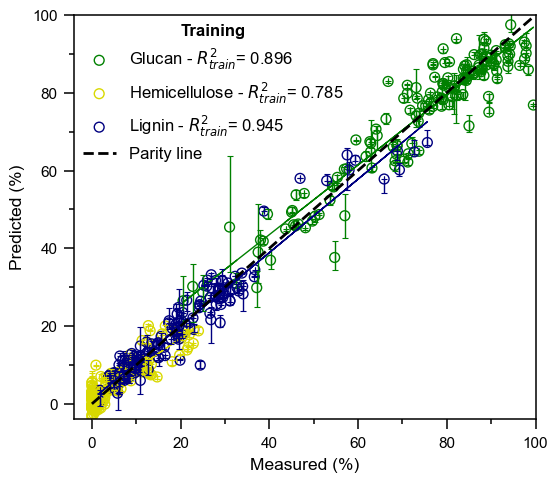

In [8]:
y_train, uncertainty_train_up, uncertainty_train_down = uncertainty_estimation_spectra_measurement(pls, X_train, X_train_min, X_train_max)
plot_parity_with_uncertainty(comp_vals_train, y_hat_train, uncertainty_train_down, uncertainty_train_up, labels=['Glucan', 'Hemicellulose', 'Lignin'], legend_title='Training', save=True, savename='UncertaintyResults/Figures/TrainingParity_spectralerror.png')

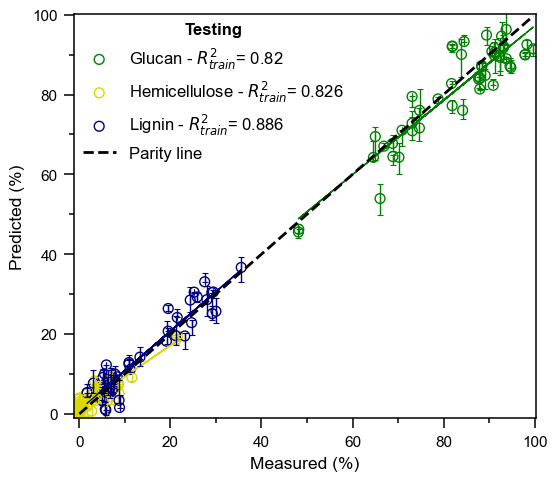

In [9]:
y_test, uncertainty_test_up, uncertainty_test_down = uncertainty_estimation_spectra_measurement(pls, X_test, X_test_min, X_test_max)
plot_parity_with_uncertainty(comp_vals_test, y_hat_test, uncertainty_test_down, uncertainty_test_up, labels=['Glucan', 'Hemicellulose', 'Lignin'], legend_title='Testing', save=True, savename='UncertaintyResults/Figures/TestingParity_spectralerror.png')

# Visualising Uncertainty - Violin plots

The following cells show how the violin plots in the paper were generated. The data is first imported from an excel file. The models are then ran and the results plotted

## Data Import and Uncertainty Estimation

The data is first imported from the excel sheet containing the spectral data for the uncertainty estimation

In [10]:
file_name="Data_Uncertainty.xlsx" # Imports the training and testing data from the excel file
_, wavelength_uncert, spectra_raw_uncert=file_import(file_name,'Reflectance') # Extracts the spectral data and the wavelength
sample_names=pd.read_excel(file_name, sheet_name="Names",header=0).loc[:,'Sample Name'].values
np.nan_to_num(spectra_raw_uncert,copy=False)
training_set_uncert = [True]*sample_names.shape[0] # Gets the indices of the training set
testing_set_uncert = [True]*sample_names.shape[0] # Gets the indices of the testing set

spectra_raw_avg_uncert=spectra_avg(spectra_raw_uncert, num_repeats=4) # Averages the spectral data (Assumes 4 repeats)

dataset_needed = 'SNV' ; low_nm = 948 ; up_nm = 2500
ind = preprocess_labels.index(dataset_needed)

_, _, X_run_all = preprocessing_combined(low_nm, up_nm, spectra_raw_avg_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run = X_run_all[:,:,ind]

(389, 51)
(389, 51)


#### Uncertainty Estimation cells (can be skipped)

The model is then loaded and the samples run. As before, this can be skipped as it will take about an hour to run the models

In [ ]:
filename = 'Uncertainty_Models/CharModel.pkl'
pls = pkl.load(open(filename, 'rb'))

In [ ]:
y_ovr_run = uncertainty_estimation(pls, X_run, n_points = 100)
filename_run = 'UncertaintyResults/pls_uncertainty_results_violin.pkl'
pkl.dump(y_ovr_run, open(filename_run,'wb'))

#### Plotting Cells

The estimation results can be loaded from the saved file

In [11]:
filename_run = 'UncertaintyResults/pls_uncertainty_results_violin.pkl'
y_ovr_run = pkl.load(open(filename_run, 'rb'))
y_hat_run, y_pos_run, y_dens_run = y_ovr_run

The alternative uncertainty estimation from the measurement uncertainty is also performed. This provides additional insight into the confidence of the model predictions

In [12]:
spectra_raw_min_uncert, spectra_raw_max_uncert=spectra_minmax(spectra_raw_uncert)

_, _, X_run_all_min = preprocessing_combined(low_nm, up_nm, spectra_raw_min_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run_min = X_run_all_min[:,:,ind]

_, _, X_run_all_max = preprocessing_combined(low_nm, up_nm, spectra_raw_max_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run_max = X_run_all_max[:,:,ind]

y_run, uncertainty_run_up, uncertainty_run_down = uncertainty_estimation_spectra_measurement(pls, X_run, X_run_min, X_run_max)

(389, 51)
(389, 51)
(389, 51)
(389, 51)


### Plotting - IonoSolv-based pulps

Once all the data is available, the results can be plotted. The next 4 cells are for ionoSolv based pulps for:
* Miscanthus - 170 C - time course
* Miscanthus - 150 C - time course
* Poplar 150 C - time course
* Pine 150 C - different particle sizes

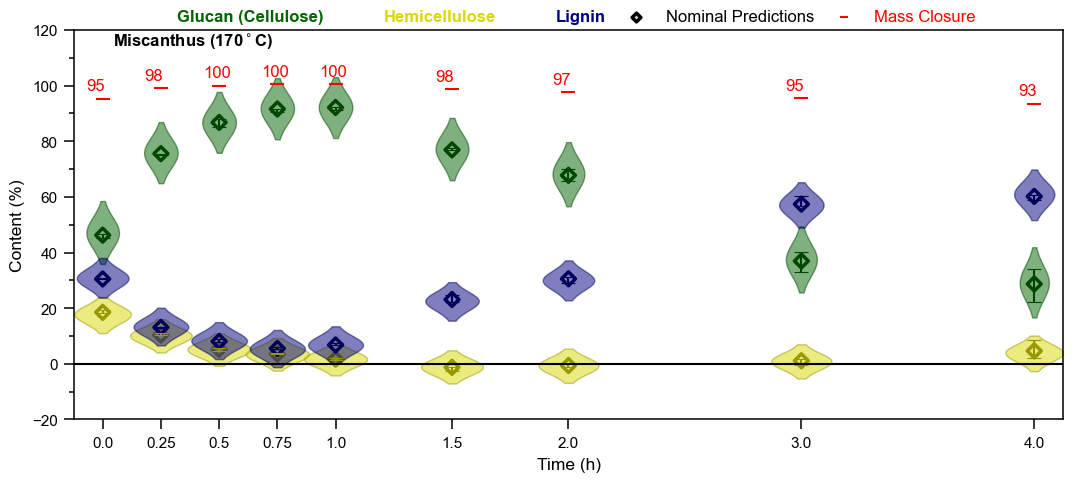

In [13]:
ind_plot = [0,1,2,3,4,5,6,7,8]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = np.array([0,0.25,0.5,0.75,1,1.5,2,3,4]) ; subplot_labels = ['Miscanthus (170$^\circ$C)']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/Miscanthus170C')

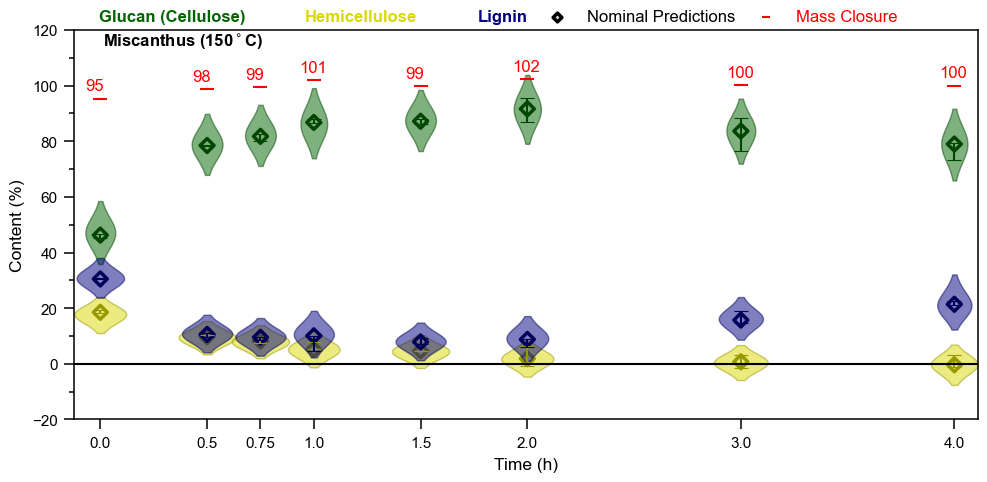

In [14]:
ind_plot = [0,9,10,11,12,13,14,15]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = np.array([0,0.5,0.75,1,1.5,2,3,4]) ; subplot_labels = ['Miscanthus (150$^\circ$C)']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/Miscanthus150C')

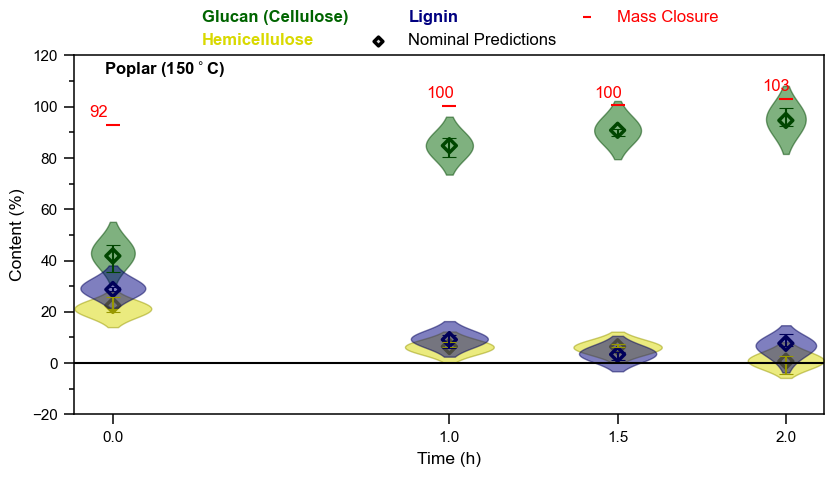

In [15]:
ind_plot = [16,17,18,19]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = np.array([0,1,1.5,2]) ; subplot_labels = ['Poplar (150$^\circ$C)']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/Poplar150C')

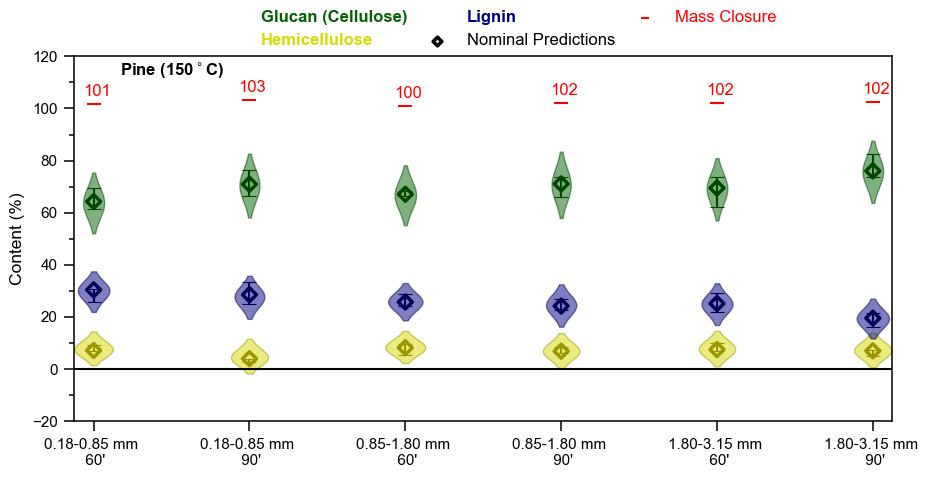

In [16]:
ind_plot = [20, 21, 22, 23, 24, 25]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Pine (150$^\circ$C)'] ; multiline_label = 'mm ' ; common_string = ['Pine ', '150 C']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, multiline_label=multiline_label, common_string=common_string, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/Pine150C')

### Plotting - samples from other pretreatments

Other samples are also tested from other pretreatment processes. Here they were:
* Non-IonoSolv pulps
* Pure Cellulose samples
* Isolated Lignin samples

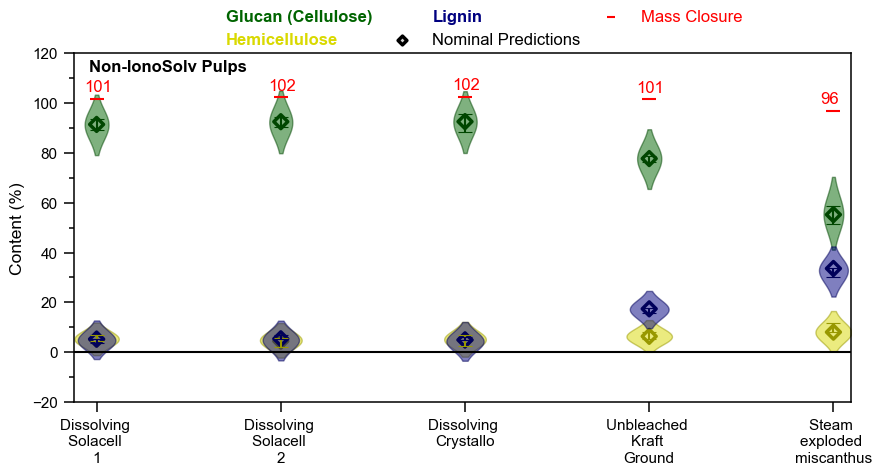

In [17]:
ind_plot = [26, 27, 28, 29, 30]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Non-IonoSolv Pulps'] ; multiline_label = ' ' ; common_string = ['Pulp ']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, multiline_label=multiline_label, common_string=common_string, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/NonIonoSolvPulps')

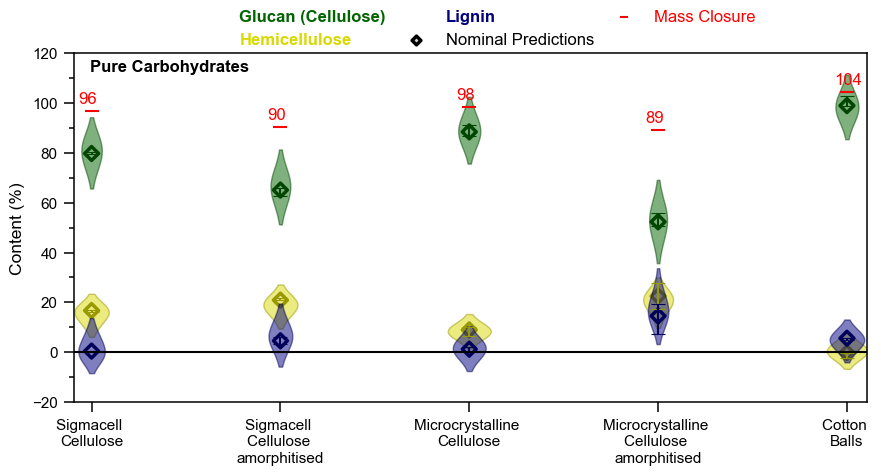

In [18]:
ind_plot = [31, 32, 33, 34, 35]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Pure Carbohydrates'] ; multiline_label = ' ' ; common_string = ['Miscanthus ']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, multiline_label=multiline_label, common_string=common_string, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/PureCarbohydrates')

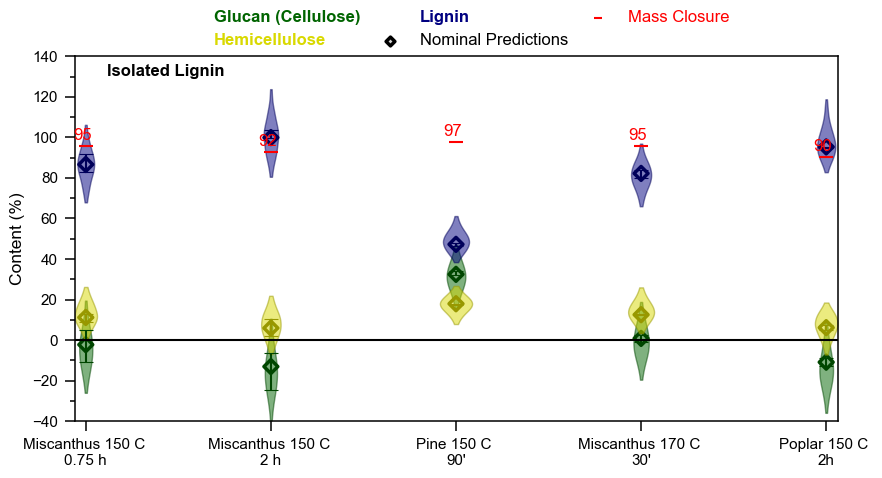

In [19]:
ind_plot = [36, 37, 38, 39, 40]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]
y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Isolated Lignin'] ; multiline_label = 'C ' ; common_string = ['Lignin ']

violin_plot(y_pos_plot, y_dens_plot, y_hat_plot, y_test_plot, sample_names_plot, uncertainty_plot_up, uncertainty_plot_down, y_test_plot, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, multiline_label=multiline_label, common_string=common_string, ha_plt = 'center', save_fig=True, save_name='UncertaintyResults/Figures/IsolatedLignin')

## Pseudo-lignin Content Estimation - Model Comparison

For the alternative model that did not include charred samples, the spectral data is first preprocessed as before. This model also uses SNV preprocessing but has different lower wavelength range of 800 nm instead of 948 nm for the original model

In [20]:
dataset_needed = 'SNV' ; low_nm_nonchar = 800 ; up_nm = 2500
ind = preprocess_labels.index(dataset_needed)

_, _, X_run_all_nonchar = preprocessing_combined(low_nm_nonchar, up_nm, spectra_raw_avg_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run_nonchar = X_run_all_nonchar[:,:,ind]

(426, 51)
(426, 51)


In [21]:
filename = 'Uncertainty_Models/NonCharModel.pkl'
pls_nonchar = pkl.load(open(filename, 'rb'))

#### Uncertainty estimation cells (can be skipped)

The separate non-char model is then loaded and then run. This can again be skipped

In [ ]:
y_ovr_run_nonchar = uncertainty_estimation(pls_nonchar, X_run, n_points = 100)
filename_run_nonchar = 'UncertaintyResults/pls_uncertainty_results_violin_nonchar.pkl'
pkl.dump(y_ovr_run_nonchar, open(filename_run_nonchar,'wb'))

#### Plotting cells

The results for the estimation with the non-char model can then be imported. Again, the alternative uncertainty estimation is performed

In [22]:
filename_run_nonchar = 'UncertaintyResults/pls_uncertainty_results_violin_nonchar.pkl'
y_ovr_run_nonchar = pkl.load(open(filename_run_nonchar, 'rb'))
y_hat_run_nonchar, y_pos_run_nonchar, y_dens_run_nonchar = y_ovr_run_nonchar

In [23]:
_, _, X_run_all_min_nonchar = preprocessing_combined(low_nm_nonchar, up_nm, spectra_raw_min_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run_min_nonchar = X_run_all_min_nonchar[:,:,ind]

_, _, X_run_all_max_nonchar = preprocessing_combined(low_nm_nonchar, up_nm, spectra_raw_max_uncert, wavelength, spectra_raw_uncert, training_set_uncert, testing_set_uncert)
X_run_max_nonchar = X_run_all_max_nonchar[:,:,ind]

y_run_nonchar, uncertainty_run_up_nonchar, uncertainty_run_down_nonchar = uncertainty_estimation_spectra_measurement(pls_nonchar, X_run_nonchar, X_run_min_nonchar, X_run_max_nonchar)

(426, 51)
(426, 51)
(426, 51)
(426, 51)


### Plotting - Model comparison

Results for different sample types can be plotted. In these violin plots, the results of both the original and non-char model are plotted to show how humins-based pseudo-lignin content can be estimated by exploiting the difference between both models. The results are shown for:

* Miscanthus - 150 C - time course
* Miscanthus - 150 C - time course
* Miscanthus - 170 C - charred samples only
* Humins - different carbohydrate precursors

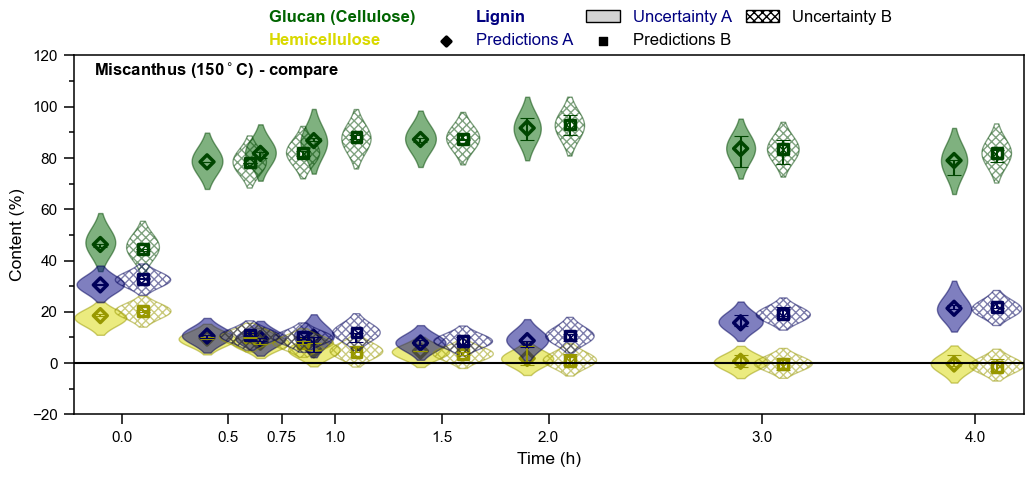

In [24]:
ind_plot = [0,9,10,11,12,13,14,15]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]

y_hat_plot_nonchar = y_hat_run_nonchar[ind_plot,:] ; y_pos_plot_nonchar = y_pos_run_nonchar[ind_plot,:,:] ; y_dens_plot_nonchar = y_dens_run_nonchar[ind_plot,:,:]
uncertainty_plot_up_nonchar = uncertainty_run_up_nonchar[ind_plot,:] ; uncertainty_plot_down_nonchar = uncertainty_run_down_nonchar[ind_plot,:]

y_hat_plot_all = [y_hat_plot, y_hat_plot_nonchar] ; y_pos_plot_all = [y_pos_plot, y_pos_plot_nonchar] ; y_dens_plot_all = [y_dens_plot, y_dens_plot_nonchar]
uncertainty_plot_up_all = [uncertainty_plot_up, uncertainty_plot_up_nonchar] ; uncertainty_plot_down_all = [uncertainty_plot_down, uncertainty_plot_down_nonchar]

y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = np.array([0,0.5,0.75,1,1.5,2,3,4]) ; subplot_labels = ['Miscanthus (150$^\circ$C) - compare']

violin_plot_compare(y_pos_plot_all, y_dens_plot_all, y_hat_plot_all, y_test_plot, sample_names_plot, uncertainty_plot_up_all, uncertainty_plot_down_all, y_comp_err, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', mass_closure=False, save_fig=True, save_name='UncertaintyResults/Figures/Miscanthus150C_Compare')

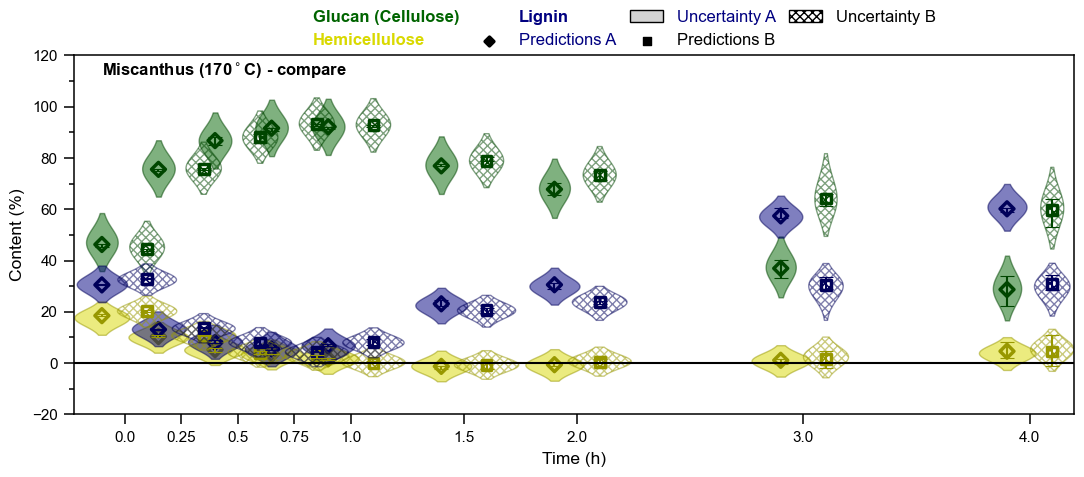

In [25]:
ind_plot = [0,1,2,3,4,5,6,7,8]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]

y_hat_plot_nonchar = y_hat_run_nonchar[ind_plot,:] ; y_pos_plot_nonchar = y_pos_run_nonchar[ind_plot,:,:] ; y_dens_plot_nonchar = y_dens_run_nonchar[ind_plot,:,:]
uncertainty_plot_up_nonchar = uncertainty_run_up_nonchar[ind_plot,:] ; uncertainty_plot_down_nonchar = uncertainty_run_down_nonchar[ind_plot,:]

y_hat_plot_all = [y_hat_plot, y_hat_plot_nonchar] ; y_pos_plot_all = [y_pos_plot, y_pos_plot_nonchar] ; y_dens_plot_all = [y_dens_plot, y_dens_plot_nonchar]
uncertainty_plot_up_all = [uncertainty_plot_up, uncertainty_plot_up_nonchar] ; uncertainty_plot_down_all = [uncertainty_plot_down, uncertainty_plot_down_nonchar]

y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = np.array([0,0.25,0.5,0.75,1,1.5,2,3,4]) ; subplot_labels = ['Miscanthus (170$^\circ$C) - compare']

violin_plot_compare(y_pos_plot_all, y_dens_plot_all, y_hat_plot_all, y_test_plot, sample_names_plot, uncertainty_plot_up_all, uncertainty_plot_down_all, y_comp_err, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', mass_closure=False, save_fig=True, save_name='UncertaintyResults/Figures/Miscanthus170C_Compare')

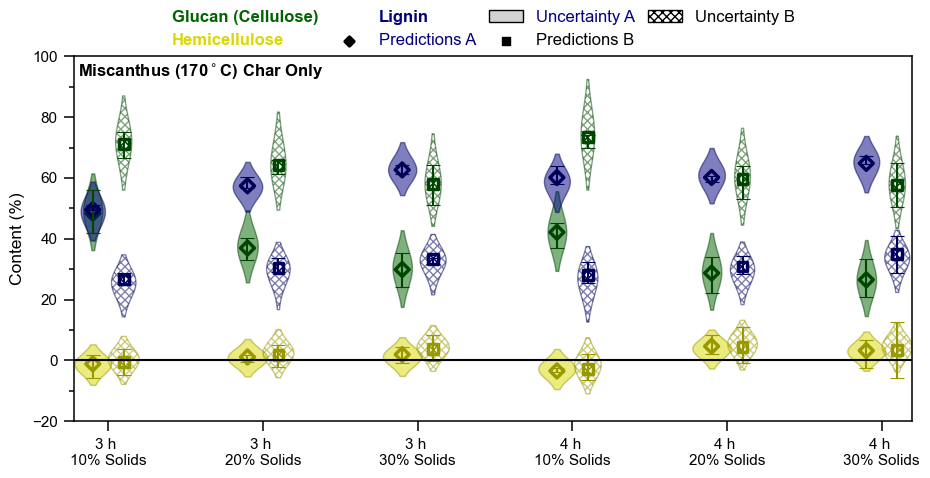

In [26]:
ind_plot = [41,7,42,43,8,44]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]

y_hat_plot_nonchar = y_hat_run_nonchar[ind_plot,:] ; y_pos_plot_nonchar = y_pos_run_nonchar[ind_plot,:,:] ; y_dens_plot_nonchar = y_dens_run_nonchar[ind_plot,:,:]
uncertainty_plot_up_nonchar = uncertainty_run_up_nonchar[ind_plot,:] ; uncertainty_plot_down_nonchar = uncertainty_run_down_nonchar[ind_plot,:]

y_hat_plot_all = [y_hat_plot, y_hat_plot_nonchar] ; y_pos_plot_all = [y_pos_plot, y_pos_plot_nonchar] ; y_dens_plot_all = [y_dens_plot, y_dens_plot_nonchar]
uncertainty_plot_up_all = [uncertainty_plot_up, uncertainty_plot_up_nonchar] ; uncertainty_plot_down_all = [uncertainty_plot_down, uncertainty_plot_down_nonchar]

y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Miscanthus (170$^\circ$C) Char Only'] ; common_string = ['Miscanthus ', '170 C, '] ; multiline_label = 'h '

violin_plot_compare(y_pos_plot_all, y_dens_plot_all, y_hat_plot_all, y_test_plot, sample_names_plot, uncertainty_plot_up_all, uncertainty_plot_down_all, y_comp_err, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', mass_closure=False, common_string=common_string, multiline_label=multiline_label, save_fig=True, save_name='UncertaintyResults/Figures/Miscanthus170C_CharOnlyCompare')

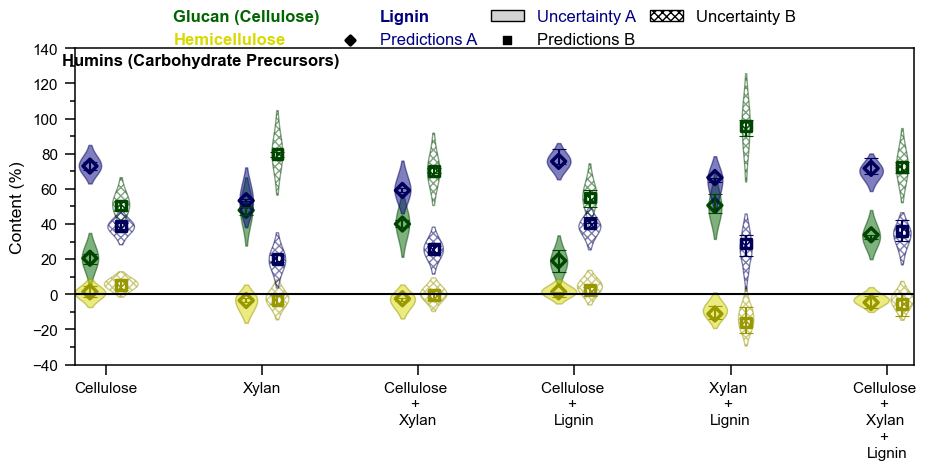

In [27]:
ind_plot = [45, 46, 47, 48, 49, 50]
y_hat_plot = y_hat_run[ind_plot,:] ; y_pos_plot = y_pos_run[ind_plot,:,:] ; y_dens_plot = y_dens_run[ind_plot,:,:] ; sample_names_plot = sample_names[ind_plot]
uncertainty_plot_up = uncertainty_run_up[ind_plot,:] ; uncertainty_plot_down = uncertainty_run_down[ind_plot,:]

y_hat_plot_nonchar = y_hat_run_nonchar[ind_plot,:] ; y_pos_plot_nonchar = y_pos_run_nonchar[ind_plot,:,:] ; y_dens_plot_nonchar = y_dens_run_nonchar[ind_plot,:,:]
uncertainty_plot_up_nonchar = uncertainty_run_up_nonchar[ind_plot,:] ; uncertainty_plot_down_nonchar = uncertainty_run_down_nonchar[ind_plot,:]

y_hat_plot_all = [y_hat_plot, y_hat_plot_nonchar] ; y_pos_plot_all = [y_pos_plot, y_pos_plot_nonchar] ; y_dens_plot_all = [y_dens_plot, y_dens_plot_nonchar]
uncertainty_plot_up_all = [uncertainty_plot_up, uncertainty_plot_up_nonchar] ; uncertainty_plot_down_all = [uncertainty_plot_down, uncertainty_plot_down_nonchar]

y_test_plot = np.zeros((sample_names_plot.shape[0],3)) ; y_comp_err = np.zeros((sample_names_plot.shape[0],3))
time_plt = [] ; subplot_labels = ['Humins (Carbohydrate Precursors)'] ; common_string = [' + IL'] ; multiline_label = ' '

violin_plot_compare(y_pos_plot_all, y_dens_plot_all, y_hat_plot_all, y_test_plot, sample_names_plot, uncertainty_plot_up_all, uncertainty_plot_down_all, y_comp_err, sort_uncertainty=False, time_plt = time_plt, subplot_labels=subplot_labels, label_rotation=0, ha_plt = 'center', mass_closure=False, common_string=common_string, multiline_label=multiline_label, save_fig=True, save_name='UncertaintyResults/Figures/Humins_Compare')